# Unified Plotting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#pi0scaling = {"val": 0, "suffix": "", "title": "No pi0 Scaling"} #no scaling
#pi0scaling = {"val": 1, "suffix": "_pi0flat", "title": "0.759 pi0 Scaling"} #flat scaling
pi0scaling = {"val": 2, "suffix": "_pi0e035", "title": "Energy-dependent pi0 Scaling"} #energy-dependent


In [3]:
from matplotlib import pyplot as plt

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
plt.rcParams.update(params)

from load_data_run123 import *
from unblinding_far_sideband import *

In [4]:
import sys
import localSettings as ls
print(ls.main_path)
main_path = ls.main_path
sys.path.append(main_path)

/home/david/data/searchingfornues/v08_00_00_33/cc0pinp/0304/


In [5]:
import scipy.stats

In [6]:
#which_sideband = ['np_far'       ,"farsideband"] # far-sideband 1eNp datasets
#which_sideband = ['0p_far'       ,"farsideband"] # far-sideband 1eNp datasets
#which_sideband = ['numu',"numu"] # numu NTuples [v41]
#which_sideband = ['2plus_showers',"farsideband"] # far-sideband 2+ shower datasets
#which_sideband = ['opendata'     ,'opendata']    # open datasets (5e19 / 1e19)
which_sideband = ['opendata'     ,'fakeset1']    # set1 fake dataset

In [7]:
samples = load_data_run123(which_sideband=which_sideband[0], return_plotter=False,\
                           pi0scaling=pi0scaling["val"],loadpi0variables=False,
                           loadshowervariables=True,loadfakedata=True)


/home/david/Neutrinos/NUE/PELEE3/load_data_run123.py:508: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_dataset['run2'] = np.ones(len(r_dataset), dtype=bool)
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] 

In [8]:
import plotter
import unblinding_far_sideband
import importlib
importlib.reload(plotter)
importlib.reload(unblinding_far_sideband)

<module 'unblinding_far_sideband' from '/home/david/Neutrinos/NUE/PELEE3/unblinding_far_sideband.py'>

In [9]:
plotter_runbyrun = {}
for run in [1, 2, 3, 123, 12]:
    this_weights, this_pot = get_weights(run,dataset=which_sideband[1])
    plotter_runbyrun[run] = plotter.Plotter(samples, this_weights, pot=this_pot)

In [10]:
TRAINVAR = ["shr_score","tksh_distance","tksh_angle",
            "shr_tkfit_dedx_max",
            "trkfit","trkpid",
            "subcluster","shrmoliereavg",
            "trkshrhitdist2","hits_ratio",
            "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","anglediff_Y",
            "CosmicIPAll3D","CosmicDirAll3D"]

pvaluetypes = ['pvalue','pvaluediag','pvaluestatonly']

# Single Variable Plotter

reco_nu_vtx_sce_x 20 (0, 260) reco nu vtx x [cm]
Error calculating the significance operands could not be broadcast together with shapes (20,) (19,) (20,) 


/home/david/Neutrinos/NUE/PELEE3/plotter.py:207: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/home/david/Neutrinos/NUE/PELEE3/plotter.py:216: RuntimeWarning: invalid value encountered in true_divide
  return (data-mc)**2 / data
/home/david/Neutrinos/NUE/PELEE3/plotter.py:212: RuntimeWarning: invalid value encountered in true_divide
  return (data-mc)**2 / mc
/home/david/Neutrinos/NUE/PELEE3/plotter.py:367: RuntimeWarning: invalid value encountered in double_scalars
  for i, k in enumerate(num)
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


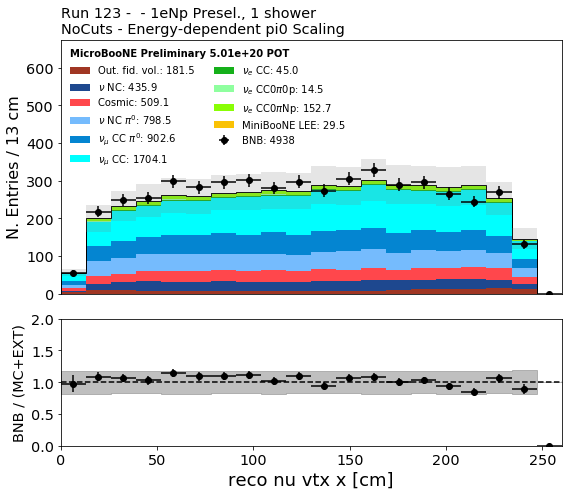

In [11]:
from unblinding_far_sideband import *

# choose sideband, preselection, and selection
# find defintions in unblinding_far_sideband.py
sdb_key = 'None'
pre_key = 'NPOneShr'
sel_key = 'None'
run = 123

sideband = sideband_categories[sdb_key]
preselection = preselection_categories[pre_key]
sel =  selection_categories[sel_key]

QUERY = ""
for query in [sideband['query'],preselection['query'],sel['query']]:
    if query is None: continue
    if QUERY: QUERY += ' and '
    QUERY += query
    if run in [1, 2, 3, 12]:
        QUERY += f' and run{run}==True'

#formatting can be improved..
TITLE = ""
for text in [f'Run {run}',' - ',sideband['title'],' - ',preselection['title'],'\n',sel['title'],' - ',pi0scaling["title"]]:
    if text is None: continue
    TITLE += text

#VARIABLE, BINS, RANGE, XTIT = 'topological_score',20,(0,1),r"topological score"
#VARIABLE, BINS, RANGE, XTIT = 'reco_e',19,(0.15,2.05),r"reco energy"
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',20,(0,260),r"reco nu vtx x [cm]"
#VARIABLE, BINS, RANGE, XTIT = 'pi0_score',10,(0,1),r"pi0 score"
#VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',10,(-0.5, 9.5),"n showers contained"
print(VARIABLE, BINS, RANGE, XTIT)

fig, ax1, ax2 = plotter_runbyrun[run].plot_variable(
    VARIABLE,   
    query=QUERY,
    kind="event_category",
    draw_sys=True,
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_ylim(0, ax1.get_ylim()[1]*1.8)

ax1.set_title(TITLE, loc='left')
#ax1.set_yscale('log')

plt.tight_layout()
fig.show()
#save_path = this_folder+VARIABLE
#fig.savefig(save_path + '.png', dpi=250)    
#plt.close()
 

In [ ]:
from significance_calculator import significanceCalculator

this_cov = plotter_runbyrun[run].cov + plotter_runbyrun[run].cov_mc_stat
expected_bin_contents = {'bg': out[3][0][-1],
                         'signal': np.zeros(out[3][0][-1].shape)}
observed_bin_contents = plotter_runbyrun[run].data
this_pot = pot_data_unblinded[which_sideband[1]][run][0]

my_signif = significanceCalculator(expected_bin_contents, pot=this_pot)
my_signif.setCovarianceMatrix(this_cov, is_cov='cov')

fig, ax = my_signif.testStatisticsWithData(0, 1, 
                                           observed_bin_contents, 
                                           chi2_pdf_superimposed=True, 
                                           n_toy=100000, 
                                           n_bins=100, 
                                           range=[0,40],
                                           title=f'Run {run}, {XTIT}, N bins = {BINS}\n',
                                           test_stat='chi2_cnp')

In [ ]:
#samples['ext'].query(unblinding_far_sideband.BDTCQ)[['run','evt','reco_e']]
samples['ext'].query(unblinding_far_sideband.BDTCQ)[['run','evt','reco_e','CosmicIPAll3D','trkpid','hits_ratio','trkfit','n_showers_contained','tksh_distance','tksh_angle']]

# Multiple variable plotting

In [ ]:
from unblinding_far_sideband import *

# choose sideband, preselection, and selection(s)
# find defintions in unblinding_far_sideband.py
#sdb_key = 'HiE' #'TwoPShr'
#pre_key = 'NPOneShr' #'NP'
#sel_keys = ['None','NPVL','NPL','NPBDT'] #['None','NPVLAllShr','NPLAllShr','NPBDTAllShr']
#sdb_key = 'TwoPShr'
#pre_key = 'NP'
#sel_keys = ['NPVLAllShr'] #['None','NPVLAllShr','NPLAllShr','NPBDTAllShr']
sdb_key = 'None'
pre_key = 'NP'
sel_keys = ['None','NPVL']
runs = [1] #[1,2,3,12,123]

sideband = sideband_categories[sdb_key]
preselection = preselection_categories[pre_key]

for run in runs:
    for sel_key in sel_keys:
        sel =  selection_categories[sel_key]
        print('\nRun %i, %s, %s, %s'%(run, sideband['dir'], preselection['dir'], sel['dir']))
        if (which_sideband[1] != "opendata"):
            this_folder = ls.plots_path+'PELEE_far_sideband_runbyrun/'
        else:
            this_folder = ls.plots_path+'PELEE_opendata/'
        this_folder += 'run_{}/'.format(run)
        this_folder += '{}_{}_{}'.format(sideband['dir'], preselection['dir'], sel['dir'])
        this_folder += (pi0scaling["suffix"]+'/')
        !mkdir -p $this_folder

        this_query = ""
        for query in [sideband['query'],preselection['query'],sel['query']]:
            if query is None: continue
            if this_query: this_query += ' and '
            this_query += query
        if run in [1, 2, 3, 12]:
            this_query += f' and run{run}==True'

        #formatting can be improved..
        this_title = ""
        for text in [f'Run {run}',' - ',sideband['title'],' - ',preselection['title'],'\n',sel['title'],' - ',pi0scaling["title"]]:
            if text is None: continue
            this_title += text

        pvalues = [[] for _ in range(len(pvaluetypes))]
        
        for plot_variable in plot_variables:
            VARIABLE, BINS, RANGE, XTIT = plot_variable[0:4]
            #if VARIABLE != 'tksh_angle': continue
            #if len(plot_variable)>4 or VARIABLE not in TRAINVAR: continue
            print(VARIABLE, BINS, RANGE, XTIT)
            fig, ax1, ax2 = plotter_runbyrun[run].plot_variable(
                VARIABLE,   
                query=this_query,
                kind="event_category",
                draw_sys=True,
                stacksort=3,
                title=XTIT,
                bins=BINS,
                range=RANGE,
            )[0:3]

            if len(plot_variable) == 6:
                if plot_variable[5] is True:
                    ax1.set_yscale('log')
            else:
                ax1.set_ylim(0, ax1.get_ylim()[1]*1.8)

            ax1.set_title(this_title, loc='left')

            plt.tight_layout()
            save_path = this_folder+VARIABLE
            if len(plot_variable) >= 5:
                save_path += ('_' + plot_variable[4])
            fig.savefig(save_path + '.png', dpi=250)    
            plt.close()
            # store pvalues
            if len(plot_variable)==4 and VARIABLE in TRAINVAR:
                for idx, pvt in enumerate(pvaluetypes):
                    pvalues[idx].append(plotter_runbyrun[run].stats[pvt])
            #print ('%s %.04f'%(VARIABLE,plotter_runbyrun[run].stats['chisqstatonly']))
            print('%s %.4f %.4f %.4f' % (VARIABLE, plotter_runbyrun[run].stats['pvaluestatonly'], plotter_runbyrun[run].stats['pvaluediag'], plotter_runbyrun[run].stats['pvalue']))
        # make pvalue plots
        #print(pvalues)
        for idx, pvt in enumerate(pvaluetypes):
            if len(pvalues[idx])!=16: continue
            plt.figure(figsize=(9, 7))
            plt.hist(pvalues[idx], bins=10, range=(0,1))
            plt.title(this_title, loc='left')
            plt.xlabel(pvt)
            plt.ylabel("number of BDT input variables")
            plt.savefig(this_folder + pvt + '.png', dpi=250)
            plt.close()

In [ ]:
samples['data'].query(BDTCQ)[["run","sub","evt","reco_e","pi0_score","nonpi0_score","n_tracks_contained","reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z"]]